In [18]:
## Converting String in to Float
## Checking Missing Values 
## Treating Missing Values 
## Statistics
## checking correlation using pearson method
## VectorAssembler
## Standard Scaling
## PCA 

In [72]:
import pyspark
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession

from pyspark.mllib.feature import StandardScaler,PCA
from pyspark.mllib.stat import Statistics

from pyspark.ml.feature import VectorAssembler
import seaborn as sns

In [20]:
spark = SparkSession.builder.appName("DataFrame Preprocessing").getOrCreate()

In [21]:
dataset = spark.read.csv("Regression/Admission_Prediction.csv",header=True)

In [22]:
dataset.show()

+---------+-----------+-----------------+----+----+----+--------+---------------+
|GRE Score|TOEFL Score|University Rating| SOP| LOR|CGPA|Research|Chance of Admit|
+---------+-----------+-----------------+----+----+----+--------+---------------+
|   337.00|     118.00|                4|4.50|4.50|9.65|    1.00|           0.92|
|   324.00|     107.00|                4|4.00|4.50|8.87|    1.00|           0.76|
|     null|     104.00|                3|3.00|3.50|8.00|    1.00|           0.72|
|   322.00|     110.00|                3|3.50|2.50|8.67|    1.00|           0.80|
|   314.00|     103.00|                2|2.00|3.00|8.21|    0.00|           0.65|
|   330.00|     115.00|                5|4.50|3.00|9.34|    1.00|           0.90|
|   321.00|     109.00|             null|3.00|4.00|8.20|    1.00|           0.75|
|   308.00|     101.00|                2|3.00|4.00|7.90|    0.00|           0.68|
|   302.00|     102.00|                1|2.00|1.50|8.00|    0.00|           0.50|
|   323.00|     

In [23]:
dataset.printSchema()

root
 |-- GRE Score: string (nullable = true)
 |-- TOEFL Score: string (nullable = true)
 |-- University Rating: string (nullable = true)
 |-- SOP: string (nullable = true)
 |-- LOR: string (nullable = true)
 |-- CGPA: string (nullable = true)
 |-- Research: string (nullable = true)
 |-- Chance of Admit: string (nullable = true)



# Converting String in to Float

In [24]:
from pyspark.sql.functions import col
new_data = dataset.select(*(col(c).cast("float").alias(c) for c in dataset.columns))

In [25]:
new_data.printSchema()

root
 |-- GRE Score: float (nullable = true)
 |-- TOEFL Score: float (nullable = true)
 |-- University Rating: float (nullable = true)
 |-- SOP: float (nullable = true)
 |-- LOR: float (nullable = true)
 |-- CGPA: float (nullable = true)
 |-- Research: float (nullable = true)
 |-- Chance of Admit: float (nullable = true)



## Another way

In [37]:
dataset = spark.read.option("inferSchema", "true").csv("Regression/Admission_Prediction.csv",header=True)
dataset.printSchema()

root
 |-- GRE Score: double (nullable = true)
 |-- TOEFL Score: double (nullable = true)
 |-- University Rating: integer (nullable = true)
 |-- SOP: double (nullable = true)
 |-- LOR: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Research: double (nullable = true)
 |-- Chance of Admit: double (nullable = true)



# Check Missing Value

In [27]:
from pyspark.sql.functions import when, col, count, isnan, filter
dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns]).show()

+---------+-----------+-----------------+---+---+----+--------+---------------+
|GRE Score|TOEFL Score|University Rating|SOP|LOR|CGPA|Research|Chance of Admit|
+---------+-----------+-----------------+---+---+----+--------+---------------+
|       15|         10|               15|  0|  0|   0|       0|              0|
+---------+-----------+-----------------+---+---+----+--------+---------------+



In [28]:
dataset.count()

500

In [31]:
data_without_missing = dataset.dropna(how='any')
#data_without_missing = dataset.dropna(how='all')

In [32]:
data_without_missing.count()

460

In [33]:
data_without_missing = dataset.dropna(how='all')
data_without_missing.count()

500

# Impute missing column

In [38]:
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=["GRE Score","TOEFL Score","University Rating"],
                 outputCols=["GRE Score","TOEFL Score","University Rating"], strategy='mean')
model = imputer.fit(dataset)
imputed_data = model.transform(dataset)

In [39]:
imputed_data.count()

500

In [40]:
from pyspark.sql.functions import col, count, isnan, when
#checking for null ir nan type values in our columns
imputed_data.select([count(when(col(c).isNull(), c)).alias(c) for c in imputed_data.columns]).show()

+---------+-----------+-----------------+---+---+----+--------+---------------+
|GRE Score|TOEFL Score|University Rating|SOP|LOR|CGPA|Research|Chance of Admit|
+---------+-----------+-----------------+---+---+----+--------+---------------+
|        0|          0|                0|  0|  0|   0|       0|              0|
+---------+-----------+-----------------+---+---+----+--------+---------------+



# Correction

In [42]:
imputed_data.corr('SOP','Research')

0.40811584579179017

# Select data for feature 

In [43]:
features = imputed_data.drop('Chance of Admit')

In [44]:
# we need to convert dataframe intp a RDD to check for correlation
col_names = features.columns
features_rdd = features.rdd

In [45]:
features_rdd.collect()

[Row(GRE Score=337.0, TOEFL Score=118.0, University Rating=4, SOP=4.5, LOR=4.5, CGPA=9.65, Research=1.0),
 Row(GRE Score=324.0, TOEFL Score=107.0, University Rating=4, SOP=4.0, LOR=4.5, CGPA=8.87, Research=1.0),
 Row(GRE Score=316.55876288659795, TOEFL Score=104.0, University Rating=3, SOP=3.0, LOR=3.5, CGPA=8.0, Research=1.0),
 Row(GRE Score=322.0, TOEFL Score=110.0, University Rating=3, SOP=3.5, LOR=2.5, CGPA=8.67, Research=1.0),
 Row(GRE Score=314.0, TOEFL Score=103.0, University Rating=2, SOP=2.0, LOR=3.0, CGPA=8.21, Research=0.0),
 Row(GRE Score=330.0, TOEFL Score=115.0, University Rating=5, SOP=4.5, LOR=3.0, CGPA=9.34, Research=1.0),
 Row(GRE Score=321.0, TOEFL Score=109.0, University Rating=3, SOP=3.0, LOR=4.0, CGPA=8.2, Research=1.0),
 Row(GRE Score=308.0, TOEFL Score=101.0, University Rating=2, SOP=3.0, LOR=4.0, CGPA=7.9, Research=0.0),
 Row(GRE Score=302.0, TOEFL Score=102.0, University Rating=1, SOP=2.0, LOR=1.5, CGPA=8.0, Research=0.0),
 Row(GRE Score=323.0, TOEFL Score=108

In [60]:
features.rdd.map(lambda row: row[0:]).collect()

[(337.0, 118.0, 4, 4.5, 4.5, 9.65, 1.0),
 (324.0, 107.0, 4, 4.0, 4.5, 8.87, 1.0),
 (316.55876288659795, 104.0, 3, 3.0, 3.5, 8.0, 1.0),
 (322.0, 110.0, 3, 3.5, 2.5, 8.67, 1.0),
 (314.0, 103.0, 2, 2.0, 3.0, 8.21, 0.0),
 (330.0, 115.0, 5, 4.5, 3.0, 9.34, 1.0),
 (321.0, 109.0, 3, 3.0, 4.0, 8.2, 1.0),
 (308.0, 101.0, 2, 3.0, 4.0, 7.9, 0.0),
 (302.0, 102.0, 1, 2.0, 1.5, 8.0, 0.0),
 (323.0, 108.0, 3, 3.5, 3.0, 8.6, 0.0),
 (325.0, 106.0, 3, 3.5, 4.0, 8.4, 1.0),
 (327.0, 111.0, 4, 4.0, 4.5, 9.0, 1.0),
 (316.55876288659795, 112.0, 4, 4.0, 4.5, 9.1, 1.0),
 (307.0, 109.0, 3, 4.0, 3.0, 8.0, 1.0),
 (311.0, 104.0, 3, 3.5, 2.0, 8.2, 1.0),
 (314.0, 105.0, 3, 3.5, 2.5, 8.3, 0.0),
 (317.0, 107.0, 3, 4.0, 3.0, 8.7, 0.0),
 (319.0, 106.0, 3, 4.0, 3.0, 8.0, 1.0),
 (318.0, 110.0, 3, 4.0, 3.0, 8.8, 0.0),
 (303.0, 102.0, 3, 3.5, 3.0, 8.5, 0.0),
 (312.0, 107.0, 3, 3.0, 2.0, 7.9, 1.0),
 (325.0, 114.0, 4, 3.0, 2.0, 8.4, 0.0),
 (328.0, 116.0, 5, 5.0, 5.0, 9.5, 1.0),
 (316.55876288659795, 119.0, 5, 5.0, 4.5, 9.7, 1.

In [48]:
features_rdd = features.rdd.map(lambda row: row[0:])

In [49]:
features_rdd.collect()

[(337.0, 118.0, 4, 4.5, 4.5, 9.65, 1.0),
 (324.0, 107.0, 4, 4.0, 4.5, 8.87, 1.0),
 (316.55876288659795, 104.0, 3, 3.0, 3.5, 8.0, 1.0),
 (322.0, 110.0, 3, 3.5, 2.5, 8.67, 1.0),
 (314.0, 103.0, 2, 2.0, 3.0, 8.21, 0.0),
 (330.0, 115.0, 5, 4.5, 3.0, 9.34, 1.0),
 (321.0, 109.0, 3, 3.0, 4.0, 8.2, 1.0),
 (308.0, 101.0, 2, 3.0, 4.0, 7.9, 0.0),
 (302.0, 102.0, 1, 2.0, 1.5, 8.0, 0.0),
 (323.0, 108.0, 3, 3.5, 3.0, 8.6, 0.0),
 (325.0, 106.0, 3, 3.5, 4.0, 8.4, 1.0),
 (327.0, 111.0, 4, 4.0, 4.5, 9.0, 1.0),
 (316.55876288659795, 112.0, 4, 4.0, 4.5, 9.1, 1.0),
 (307.0, 109.0, 3, 4.0, 3.0, 8.0, 1.0),
 (311.0, 104.0, 3, 3.5, 2.0, 8.2, 1.0),
 (314.0, 105.0, 3, 3.5, 2.5, 8.3, 0.0),
 (317.0, 107.0, 3, 4.0, 3.0, 8.7, 0.0),
 (319.0, 106.0, 3, 4.0, 3.0, 8.0, 1.0),
 (318.0, 110.0, 3, 4.0, 3.0, 8.8, 0.0),
 (303.0, 102.0, 3, 3.5, 3.0, 8.5, 0.0),
 (312.0, 107.0, 3, 3.0, 2.0, 7.9, 1.0),
 (325.0, 114.0, 4, 3.0, 2.0, 8.4, 0.0),
 (328.0, 116.0, 5, 5.0, 5.0, 9.5, 1.0),
 (316.55876288659795, 119.0, 5, 5.0, 4.5, 9.7, 1.

# Statistics

In [62]:
summary = Statistics.colStats(features_rdd)
print(summary.mean())  # a dense vector containing the mean value for each column
print(summary.variance())  # column-wise variance
print(summary.numNonzeros())  # number of nonzeros in each column
print(summary.normL1())# return a column of normL1 summary

[316.55876289 107.1877551    3.118        3.374        3.484
   8.57644      0.56      ]
[123.29774601  36.61869044   1.27462525   0.98208818   0.85645691
   0.36579852   0.24689379]
[500. 500. 500. 500. 500. 500. 280.]
[158279.3814433   53593.87755102   1559.           1687.
   1742.           4288.22          280.        ]


In [63]:
dataset.describe()

DataFrame[summary: string, GRE Score: string, TOEFL Score: string, University Rating: string, SOP: string, LOR: string, CGPA: string, Research: string, Chance of Admit: string]

# checking correlation using pearson method

In [66]:
corr_mat=Statistics.corr(features_rdd, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

In [67]:
corr_df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research'],
      dtype='object')

In [68]:
corr_df.index

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research'],
      dtype='object')

In [71]:
corr_df

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
GRE Score,1.000000,0.819663,0.623394,0.608372,0.527623,0.818347,0.544993
TOEFL Score,0.819663,1.000000,0.644296,0.643155,0.535785,0.805557,0.464913
University Rating,0.623394,0.644296,1.000000,0.713657,0.606949,0.697704,0.424966
SOP,0.608372,0.643155,0.713657,1.000000,0.663707,0.712154,0.408116
LOR,0.527623,0.535785,0.606949,0.663707,1.000000,0.637469,0.372526
CGPA,0.818347,0.805557,0.697704,0.712154,0.637469,1.000000,0.501311
Research,0.544993,0.464913,0.424966,0.408116,0.372526,0.501311,1.000000


<AxesSubplot:>

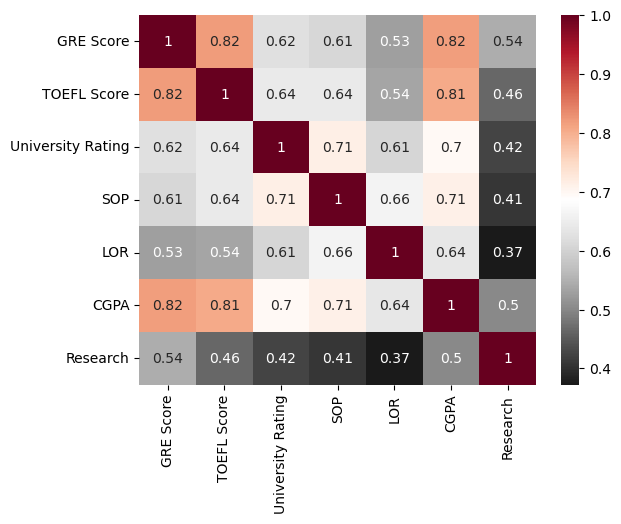

In [81]:
sns.heatmap(corr_df, annot=True, cmap='RdGy_r')

# VectorAssembler

In [82]:
imputed_data.show()

+------------------+-----------+-----------------+---+---+----+--------+---------------+
|         GRE Score|TOEFL Score|University Rating|SOP|LOR|CGPA|Research|Chance of Admit|
+------------------+-----------+-----------------+---+---+----+--------+---------------+
|             337.0|      118.0|                4|4.5|4.5|9.65|     1.0|           0.92|
|             324.0|      107.0|                4|4.0|4.5|8.87|     1.0|           0.76|
|316.55876288659795|      104.0|                3|3.0|3.5| 8.0|     1.0|           0.72|
|             322.0|      110.0|                3|3.5|2.5|8.67|     1.0|            0.8|
|             314.0|      103.0|                2|2.0|3.0|8.21|     0.0|           0.65|
|             330.0|      115.0|                5|4.5|3.0|9.34|     1.0|            0.9|
|             321.0|      109.0|                3|3.0|4.0| 8.2|     1.0|           0.75|
|             308.0|      101.0|                2|3.0|4.0| 7.9|     0.0|           0.68|
|             302.0| 

In [83]:
features = imputed_data.drop('Chance of Admit')

In [84]:
assembler = VectorAssembler(inputCols=features.columns,outputCol="features")

In [85]:
output = assembler.transform(imputed_data)

In [86]:
output.select("features", "Chance of Admit").show(truncate=False)

+----------------------------------------------+---------------+
|features                                      |Chance of Admit|
+----------------------------------------------+---------------+
|[337.0,118.0,4.0,4.5,4.5,9.65,1.0]            |0.92           |
|[324.0,107.0,4.0,4.0,4.5,8.87,1.0]            |0.76           |
|[316.55876288659795,104.0,3.0,3.0,3.5,8.0,1.0]|0.72           |
|[322.0,110.0,3.0,3.5,2.5,8.67,1.0]            |0.8            |
|[314.0,103.0,2.0,2.0,3.0,8.21,0.0]            |0.65           |
|[330.0,115.0,5.0,4.5,3.0,9.34,1.0]            |0.9            |
|[321.0,109.0,3.0,3.0,4.0,8.2,1.0]             |0.75           |
|[308.0,101.0,2.0,3.0,4.0,7.9,0.0]             |0.68           |
|[302.0,102.0,1.0,2.0,1.5,8.0,0.0]             |0.5            |
|[323.0,108.0,3.0,3.5,3.0,8.6,0.0]             |0.45           |
|[325.0,106.0,3.0,3.5,4.0,8.4,1.0]             |0.52           |
|[327.0,111.0,4.0,4.0,4.5,9.0,1.0]             |0.84           |
|[316.55876288659795,112.

# Standard Scaling

In [87]:
label = imputed_data.select('Chance of Admit')

In [88]:
label.show()

+---------------+
|Chance of Admit|
+---------------+
|           0.92|
|           0.76|
|           0.72|
|            0.8|
|           0.65|
|            0.9|
|           0.75|
|           0.68|
|            0.5|
|           0.45|
|           0.52|
|           0.84|
|           0.78|
|           0.62|
|           0.61|
|           0.54|
|           0.66|
|           0.65|
|           0.63|
|           0.62|
+---------------+
only showing top 20 rows



In [89]:
features = imputed_data.drop('Chance of Admit')

In [90]:
col_names = features.columns
features_rdd = features.rdd.map(lambda row: row[0:])

In [91]:
features_rdd.collect()

[(337.0, 118.0, 4, 4.5, 4.5, 9.65, 1.0),
 (324.0, 107.0, 4, 4.0, 4.5, 8.87, 1.0),
 (316.55876288659795, 104.0, 3, 3.0, 3.5, 8.0, 1.0),
 (322.0, 110.0, 3, 3.5, 2.5, 8.67, 1.0),
 (314.0, 103.0, 2, 2.0, 3.0, 8.21, 0.0),
 (330.0, 115.0, 5, 4.5, 3.0, 9.34, 1.0),
 (321.0, 109.0, 3, 3.0, 4.0, 8.2, 1.0),
 (308.0, 101.0, 2, 3.0, 4.0, 7.9, 0.0),
 (302.0, 102.0, 1, 2.0, 1.5, 8.0, 0.0),
 (323.0, 108.0, 3, 3.5, 3.0, 8.6, 0.0),
 (325.0, 106.0, 3, 3.5, 4.0, 8.4, 1.0),
 (327.0, 111.0, 4, 4.0, 4.5, 9.0, 1.0),
 (316.55876288659795, 112.0, 4, 4.0, 4.5, 9.1, 1.0),
 (307.0, 109.0, 3, 4.0, 3.0, 8.0, 1.0),
 (311.0, 104.0, 3, 3.5, 2.0, 8.2, 1.0),
 (314.0, 105.0, 3, 3.5, 2.5, 8.3, 0.0),
 (317.0, 107.0, 3, 4.0, 3.0, 8.7, 0.0),
 (319.0, 106.0, 3, 4.0, 3.0, 8.0, 1.0),
 (318.0, 110.0, 3, 4.0, 3.0, 8.8, 0.0),
 (303.0, 102.0, 3, 3.5, 3.0, 8.5, 0.0),
 (312.0, 107.0, 3, 3.0, 2.0, 7.9, 1.0),
 (325.0, 114.0, 4, 3.0, 2.0, 8.4, 0.0),
 (328.0, 116.0, 5, 5.0, 5.0, 9.5, 1.0),
 (316.55876288659795, 119.0, 5, 5.0, 4.5, 9.7, 1.

In [92]:
scaler1 = StandardScaler().fit(features_rdd)
scaled_features=scaler1.transform(features_rdd)

In [93]:
for data in scaled_features.collect():
    print(data)

[30.349555318794252,19.49982001499084,3.5429802588871713,4.540851219659883,4.8625015634799515,15.955350142529381,2.0125418443661425]
[29.17880095931554,17.68204018308491,3.5429802588871713,4.036312195253229,4.8625015634799515,14.665694897848248,2.0125418443661425]
[28.50865782159014,17.18628204711057,2.6572351941653785,3.027234146439922,3.7819456604844066,13.227233278780833,2.0125418443661425]
[28.998684904011125,18.177798319059256,2.6572351941653785,3.5317731708465754,2.7013897574888617,14.335014065878728,2.0125418443661425]
[28.27822068279346,17.02102933511912,1.7714901294435856,2.0181560976266146,3.2416677089866344,13.57444815234883,0.0]
[29.719149125228792,19.004061879016493,4.428725323608964,4.540851219659883,3.2416677089866344,15.442794852976622,2.0125418443661425]
[28.908626876358916,18.012545607067807,2.6572351941653785,3.027234146439922,4.322223611982179,13.557914110750353,2.0125418443661425]
[27.73787251688021,16.690523911136225,1.7714901294435856,3.027234146439922,4.32222361

# PCA

In [94]:
pca = PCA(k=3)
model = pca.fit(scaled_features)

In [95]:
result = model.transform(scaled_features)

In [96]:
result.collect()

[DenseVector([-32.1422, 7.3593, -19.6841]),
 DenseVector([-30.2035, 7.0001, -18.1891]),
 DenseVector([-28.0241, 7.7667, -18.1399]),
 DenseVector([-28.9036, 8.312, -19.4463]),
 DenseVector([-26.5155, 6.9719, -19.7442]),
 DenseVector([-31.2461, 7.6011, -19.7415]),
 DenseVector([-28.8446, 7.7397, -18.5032]),
 DenseVector([-26.7152, 5.9864, -18.595]),
 DenseVector([-24.9641, 7.5753, -20.0133]),
 DenseVector([-28.3665, 6.5551, -20.2208]),
 DenseVector([-29.1244, 7.6116, -18.3993]),
 DenseVector([-30.6681, 7.1484, -18.647]),
 DenseVector([-30.4259, 6.9261, -18.4033]),
 DenseVector([-28.2096, 7.5259, -18.2627]),
 DenseVector([-27.5909, 8.1603, -18.6783]),
 DenseVector([-27.4438, 6.5107, -19.8154]),
 DenseVector([-28.347, 6.2286, -19.8881]),
 DenseVector([-28.4453, 7.7497, -18.4455]),
 DenseVector([-28.6519, 6.3107, -20.1896]),
 DenseVector([-27.1744, 5.9735, -19.0387]),
 DenseVector([-27.4225, 8.4025, -18.9154]),
 DenseVector([-28.4642, 7.1194, -21.1574]),
 DenseVector([-32.3002, 6.4889, -18.

In [97]:
type(result)

pyspark.rdd.RDD

In [98]:
df =result.map(lambda x: (x, )).toDF(["PCA_Features"])

In [99]:
df.show(truncate=False)

+------------------------------------------------------------+
|PCA_Features                                                |
+------------------------------------------------------------+
|[-32.14218595718725,7.359269327786596,-19.684130387964373]  |
|[-30.20349375160482,7.000097916041128,-18.18913270753632]   |
|[-28.024083867036257,7.766720231798569,-18.13994240714532]  |
|[-28.903567438427515,8.3120173153309,-19.446297316023553]   |
|[-26.515537365201368,6.97186945874331,-19.744204013833297]  |
|[-31.246108949350546,7.60111689883909,-19.741454181440126]  |
|[-28.84456848518546,7.739700243856719,-18.503218871901538]  |
|[-26.71524641114005,5.986407361256873,-18.594991827635013]  |
|[-24.96408807855464,7.575303664204466,-20.01332846180375]   |
|[-28.366526066351668,6.5551485518306105,-20.220826616746784]|
|[-29.124377149324026,7.611550920786689,-18.399341716479256] |
|[-30.668077385417963,7.148403783917746,-18.64697405314155]  |
|[-30.425914131011773,6.926124582394391,-18.40334275656